In [ ]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


# ----- State -----
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    route: list[str] | None      
    sql_result: str | None
    vector_result: str | None

# ----- Tools -----
@tool
def run_sql_query(query: str):
    """Run a database query and return the results."""
    if "calls yesterday" in query.lower():
        return "42 calls were made yesterday."
    elif "today" in query.lower() or "current" in query.lower():
        return "17 calls so far today."
    else:
        return "No data found."
    
@tool
def search_vector_db(query: str):
    """Perform a semantic vector search."""
    return f"Search results for '{query}' (vector-based)."

# ----- LLMs -----
main_llm = ChatOpenAI(model="gpt-4o")
sql_llm = ChatOpenAI(model="gpt-4o-mini")
vect_llm = ChatOpenAI(model="gpt-4o-mini")
summ_llm = ChatOpenAI(model="gpt-4o-mini")

# ----- Agents -----
def main_agent(state: AgentState) -> AgentState:
    """Coordinator: decides which subagents to run."""
    system = SystemMessage(content="""
    You are the main coordinator.
    Decide which agents to run:
    - SQL agent for structured/numeric data.
    - Vector agent for semantic/fuzzy searches.
    After all subagents are done, send everything to the summarizer agent. If you don't need any subagents, answer directly and end the process.
    """)
    response = main_llm.invoke([system] + state["messages"])
    text = response.content.lower()

    # Only determine routes once
    if state.get("route") is None:
        routes = []
        if "sql" in text or "database" in text or "calls" in text:
            routes.append("sql_agent")
        if "vector" in text or "semantic" in text or "product issue" in text:
            routes.append("vector_agent")
    else:
        routes = state["route"]

    # If routes are empty, move to summarizer
    if not routes:
        return {
            "messages": state["messages"] + [response],
            "route": []
        }

    return {"messages": state["messages"] + [response], "route": routes}


sql_llm_bound = sql_llm.bind_tools([run_sql_query])
vect_llm_bound = vect_llm.bind_tools([search_vector_db])

def sql_agent(state: AgentState) -> AgentState:
    system = SystemMessage(content="You are an expert SQL query builder.")
    relevant = [m for m in state["messages"] if isinstance(m, SystemMessage) == False]
    response = sql_llm_bound.invoke([system] + relevant)    
    return {
        "messages": state["messages"] + [response],
        "sql_result": response.content
    }

def vector_agent(state: AgentState) -> AgentState:
    system = SystemMessage(content="You are an expert in semantic vector searches.")
    relevant = [m for m in state["messages"] if isinstance(m, SystemMessage) == False]
    response = sql_llm_bound.invoke([system] + relevant)    
    return {
        "messages": state["messages"] + [response],
        "vector_result": response.content
    }

def summarizer_agent(state: AgentState) -> AgentState:
    """Final summary step."""
    system = SystemMessage(content="Summarize the findings from all previous agents clearly. For the user.")
    response = summ_llm.invoke([system] + state["messages"])
    return {
        "messages": state["messages"] + [response],
        "route": []
    }

# ----- Routing Logic -----
def route_next(state: AgentState):
    routes = state.get("route") or []
    if not routes:
        return "end"
    next_route = routes.pop(0)
    state["route"] = routes
    return next_route

# ----- Graph Definition -----
graph = StateGraph(AgentState)
graph.add_node("main_agent", main_agent)
graph.add_node("sql_agent", sql_agent)
graph.add_node("vector_agent", vector_agent)
graph.add_node("sql_tools", ToolNode([run_sql_query]))
graph.add_node("vector_tools", ToolNode([search_vector_db]))
graph.add_node("summarizer_agent", summarizer_agent)

graph.set_entry_point("main_agent")

graph.add_conditional_edges("main_agent", route_next, {
    "sql_agent": "sql_agent",
    "vector_agent": "vector_agent",
    "summarizer_agent": "summarizer_agent",
    "end": END
})

graph.add_edge("sql_agent", "sql_tools")
graph.add_edge("vector_agent", "vector_tools")
graph.add_edge("sql_tools", "main_agent")
graph.add_edge("vector_tools", "main_agent")
graph.add_edge("summarizer_agent", END)

app = graph.compile()




In [15]:
def print_stream(stream):
    for s in stream:
        msg = s["messages"][-1]
        msg.pretty_print()

inputs = {
    "messages": [("user",
      "Give me the calls for today and yesterday from the database"
    )]
}

print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Give me the calls for today and yesterday from the database
================================== Ai Message ==================================

I will run an SQL query to retrieve the call records for today and yesterday from the database. Please hold on.
================================== Ai Message ==================================
Tool Calls:
  run_sql_query (call_Nsh5XWYvYped2mNqMkQSTc8O)
 Call ID: call_Nsh5XWYvYped2mNqMkQSTc8O
  Args:
    query: SELECT * FROM calls WHERE DATE(call_time) = CURDATE();
  run_sql_query (call_3SXqYApPsqEIF1U7haNRToPB)
 Call ID: call_3SXqYApPsqEIF1U7haNRToPB
  Args:
    query: SELECT * FROM calls WHERE DATE(call_time) = CURDATE() - INTERVAL 1 DAY;
================================= Tool Message =================================
Name: run_sql_query

17 calls so far today.
================================== Ai Message ==================================

Here are the call recor

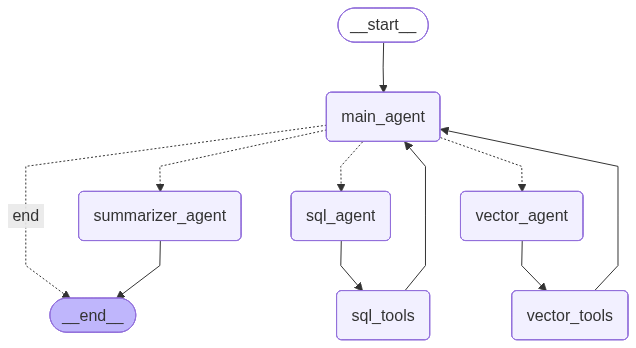

In [10]:
display(Image(app.get_graph().draw_mermaid_png()))
